# Aprenentage Supervisat - Classificació
**Descripció**. 
Anem a practicar i a familiaritzar-nos amb algoritmes de classificació.

In [47]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from IPython.display import display, Markdown

from utils import SinCosTransformer

import time
import warnings
warnings.simplefilter('ignore')

SEED = 42
TEST_SIZE = 0.2
TESTING = True

### Carreguem les dades

In [2]:
dfdelays = pd.read_pickle('../data/S11-CleanDelayedFlights.pickle')

In [3]:
dfdelays['Delayed'] = (dfdelays.ArrDelay > 0).astype('int')

In [4]:
# Fem un sample de les dades per fer el procés més ràpid 

if TESTING:
    dfdelays = dfdelays.sample(frac=0.05, random_state=SEED)
    
dfdelays.shape

(96419, 88)

### Separem en train test

In [5]:


target = ['Delayed']

cols = [col for col in dfdelays.columns if col not in target]

X_train, X_test, y_train, y_test = train_test_split(dfdelays[cols], dfdelays[target], test_size=TEST_SIZE, random_state=SEED )

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((77135, 87), (19284, 87), (77135, 1), (19284, 1))

### Preprocés

In [7]:
# columnes originals

base_cols = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 
             'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 
             'UniqueCarrier', 'AirTime', 'DepDelay', 
             'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 
             'CRSElapsedTime_c', 'ActualElapsedTime_c']


In [8]:
cols_exp4 = ['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 
            'DepDelay', 'Origin', 'Dest', 'UniqueCarrier', 'Distance', 
            'carrier_name', 'Name_Origin', 'Name_Dest', 
            'CRSElapsedTime_c', 'ActualElapsedTime_c', 
            'DepartureTime', 'CRSDepartureTime', 
            'ArrivalTime', 'CRSArrivalTime', 
            'Dep_hourlyf', 'Dep_dailyf', 'Arr_dailyf', 'Arr_hourlyf',    
            'Origin_lat', 'Origin_long', 'Dest_lat', 'Dest_long', 
            'velocity', 'CRSvelocity', 
            'DepartureTime_hour_sin', 'DepartureTime_hour_cos', 'DepartureTime_day_sin', 'DepartureTime_day_cos', 
            'DepartureTime_dayofweek_sin', 'DepartureTime_dayofweek_cos', 'DepartureTime_month_sin', 'DepartureTime_month_cos', 
            'CRSDepartureTime_hour_sin', 'CRSDepartureTime_hour_cos', 'CRSDepartureTime_day_sin', 'CRSDepartureTime_day_cos', 
            'CRSDepartureTime_dayofweek_sin', 'CRSDepartureTime_dayofweek_cos', 'CRSDepartureTime_month_sin', 'CRSDepartureTime_month_cos', 
            'ArrivalTime_hour_sin', 'ArrivalTime_hour_cos', 'ArrivalTime_day_sin', 'ArrivalTime_day_cos', 
            'ArrivalTime_dayofweek_sin', 'ArrivalTime_dayofweek_cos', 'ArrivalTime_month_sin', 'ArrivalTime_month_cos', 
            'CRSArrivalTime_hour_sin', 'CRSArrivalTime_hour_cos', 'CRSArrivalTime_day_sin', 'CRSArrivalTime_day_cos', 
            'CRSArrivalTime_dayofweek_sin', 'CRSArrivalTime_dayofweek_cos', 'CRSArrivalTime_month_sin', 'CRSArrivalTime_month_cos']


In [9]:
# amb columes noves
cols_exp5 = ['DepDelay',  'Distance', 
            'UniqueCarrier', 
            'CRSElapsedTime_c', 'ActualElapsedTime_c', 
            'DepartureTime', 'CRSDepartureTime', 
            'ArrivalTime', 'CRSArrivalTime', 
            'Dep_hourlyf', 'Dep_dailyf', 'Arr_dailyf', 'Arr_hourlyf',    
            'Origin_lat', 'Origin_long', 'Dest_lat', 'Dest_long', 
            'velocity', 'CRSvelocity']

# Eliminem el DepDelay
cols_exp6 = ['Distance', 
            'UniqueCarrier', 'Origin', 'Dest',
            'CRSElapsedTime_c', 'ActualElapsedTime_c', 
            'DepartureTime', 'CRSDepartureTime', 
            'ArrivalTime', 'CRSArrivalTime', 
            'Dep_hourlyf', 'Dep_dailyf', 'Arr_dailyf', 'Arr_hourlyf',    
            'Origin_lat', 'Origin_long', 'Dest_lat', 'Dest_long', 
            'velocity', 'CRSvelocity']

# Eliminem el DepDelay, així com dades sobre el vol real, fins i tot el DepartureTime
# No esperem un bon resultat 
cols_exp7 = ['Distance', 
            'UniqueCarrier', 'Origin', 'Dest',
            'CRSElapsedTime_c', 
            'CRSDepartureTime', 
            'CRSArrivalTime', 
            'Dep_hourlyf', 'Dep_dailyf', 'Arr_dailyf', 'Arr_hourlyf',    
            'Origin_lat', 'Origin_long', 'Dest_lat', 'Dest_long', 
            'CRSvelocity']

## Nivell 1
### Exercici 1
Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# mètriques
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


##### Preparem un parell de funcions on creem un pipeline i executem la classificació

In [11]:
def make_pipeline(data, columns, model):
    cols_num = data[columns].select_dtypes(include=['int','float']).columns.to_list()
    cols_cat = data[columns].select_dtypes(include=['object']).columns.to_list()
    cols_date = data[columns].select_dtypes(include=['datetime']).columns.to_list()
    
    ct = ColumnTransformer(
             transformers=[('num', RobustScaler(), cols_num),
                          ('cat', OneHotEncoder(handle_unknown='ignore'), cols_cat),
                          ('date', SinCosTransformer(['hour','day','dayofweek','month','weekofyear']), cols_date )])
    
    pipeline = Pipeline( steps=[('transformer', ct),
                               ('regr', model)])
    
    return pipeline

# base_pipe = make_pipeline(dfdelays, base_cols, LinearRegression())

# base_pipe.fit(dfdelays[base_cols], dfdelays[target])
# y_pred_base = base_pipe.predict(dfdelays[base_cols])
# print(f'LR r2: {r2_score(dfdelays[target], y_pred_base)}')
# print(f'LR MSE: {mean_squared_error(dfdelays[target], y_pred_base)}')

def run_experiment(train, test=None, columns=[], model=LogisticRegression(), ax=None, title=None):
    if test is None:
        X_train, X_test, y_train, y_test = train_test_split(train, 
                                                        test_size=TEST_SIZE, random_state=SEED)
    else:
        X_train, y_train = train
        X_test, y_test = test
        
    pipe = make_pipeline(X_train, columns, model)
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    if ax:
        disp = plot_roc_curve(pipe, X_test, y_test, 
                              ax=ax, name=model.__class__.__name__)
        ax.set_title(title)
        
    return accuracy_score(y_test, y_pred), \
            roc_auc_score(y_test, y_pred), \
            f1_score(y_test, y_pred), \
            confusion_matrix(y_test, y_pred)
    
    

In [12]:
models = {'lr': LogisticRegression(),
         'ridge': RidgeClassifier(),
         'tree': DecisionTreeClassifier(max_depth=7, random_state=SEED),
         'rf': RandomForestClassifier(max_depth=7, n_jobs=-1, random_state=SEED),
         'gb': GradientBoostingClassifier( random_state=SEED, criterion='mse'),
         'nn': MLPClassifier(hidden_layer_sizes=(100,50,25)),
         'xgb': XGBClassifier(n_jobs=-1, objective='binary:logistic',
                             eval_metric=['logloss','auc'])}


# params = {  'lr': {'fit_intercept':False, 'normalize': True},
#             'ridge': {'alpha':np.linspace(), 'solver':{'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'}},
#             'hub': {},
#             'tree': {},
#             'rf': {} 
#             'gb': {} 
#             'nn': {} 
#             'xgb': {}
#          }

#### Comprovem l'accuracy si tot fossin retrassos

In [45]:
display(Markdown(f'#### Accuracy: {accuracy_score(y_test, np.ones(y_test.shape)):.5f}'))

#### Accuracy: 0.89354

Veiem que per perquè l'algoritme sigui útil hauria de millorar l'accuracy obtingut de considerar tots els vols com a retrassats.
Farem uns experiments per veure com es porten els diferents algoritmes amb diferents features:

#### Experiments - Features escollits

- **Exp. min**: Només amb DepDelay
- **base**: Amb les dades originals netejades
- **exp. 3**: Amb només 'DepDelay', 'Distance','Origin', 'Dest', 'UniqueCarrier'
- **exercici 5**. Noves columnes. Velocitat, Latitut i Longitut dels aeroports, Numero de vols per hora i dia a l'aeroport de Sortida i Arribada
- **ND exp. 6**: com el 5 però sense el DepDelay
- **ND exp. 7**: Eliminem el DepDelay, així com dades sobre el vol real, fins i tot el DepartureTime. No esperem un bon resultat Experiments sense DepDelay

In [13]:
experiments = { 'Exp. min': ['DepDelay'],
              'base': base_cols, 
              'exp. 3': ['DepDelay', 'Distance','Origin', 'Dest', 'UniqueCarrier'],
              'exercici 5': cols_exp5 ,
               'ND exp. 6': cols_exp6,
               'ND exp. 7': cols_exp7 }

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

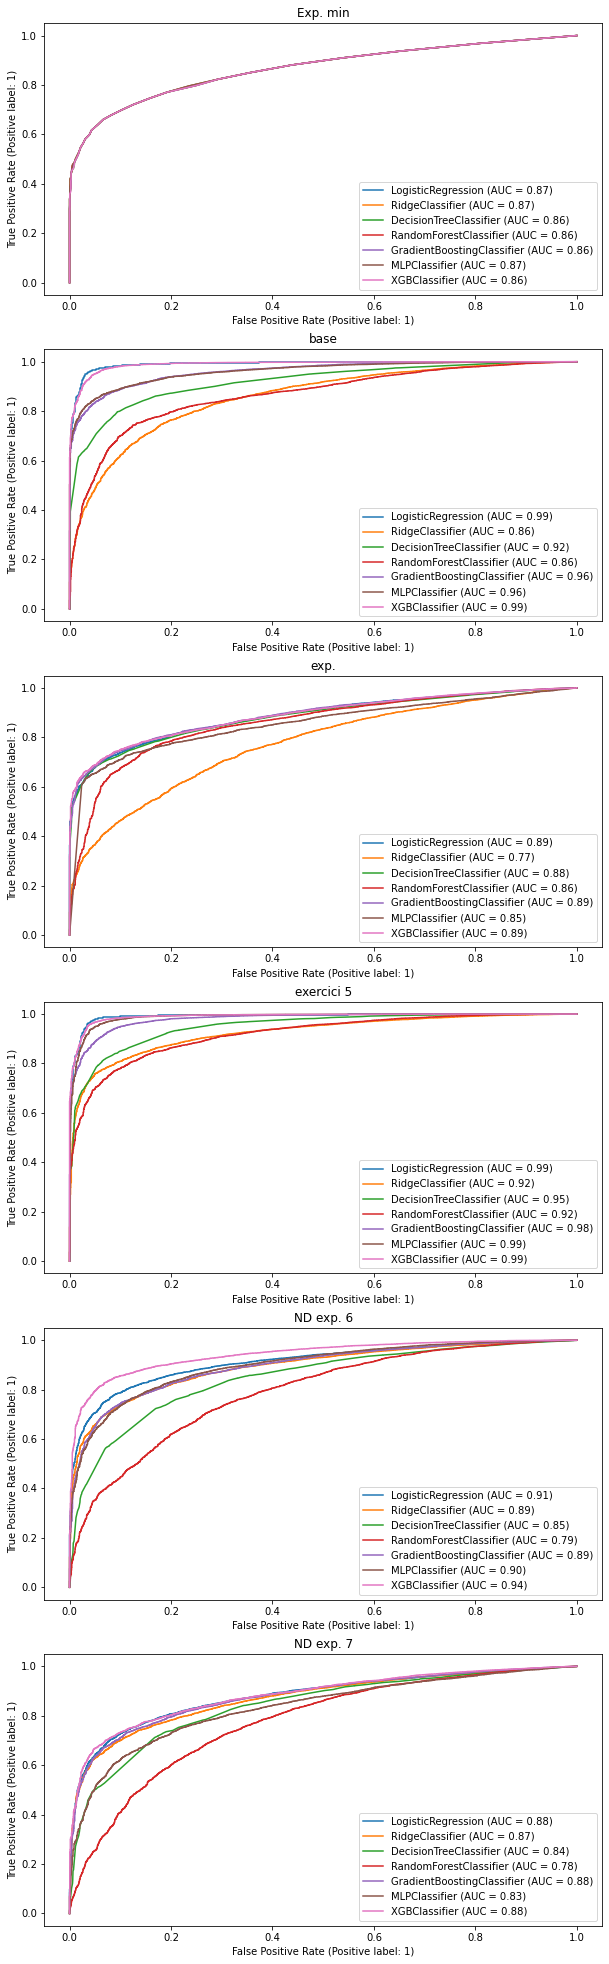

In [14]:
results = []

fig, ax = plt.subplots(len(experiments), figsize=(10,35))

for i, (exp, cols) in tqdm(enumerate(experiments.items())):
    for name, model in tqdm(models.items()):
#         print(f'{exp}: {model.__class__.__name__}')
        t0 = time.time()
        acc, auc, f1, conf_mat = run_experiment((X_train, y_train), (X_test, y_test), 
                                            cols, model, ax=ax[i], title=exp)
        results.append([name, acc, auc, conf_mat, len(cols) ,time.time()-t0, exp])
#         print(f'{exp} {name}: {model.__class__.__name__} \n\tMSE: {mse}\n\tR2 : {r2}')

dfresults =  pd.DataFrame(results, columns=['model','acc', 'auc', 'f1','conf_mat', 'num_feat','time', 'experiment'])
# dfresults

In [15]:
dfresults.pivot(index=['model'],values=['acc','auc','conf_mat','num_feat','time'],columns=['experiment'])\
            .style.set_properties(**{'background-color':'lightyellow'}, subset=['acc'])\
                .set_properties(**{'background-color':'lightgreen'}, subset=['auc'])\
                .highlight_max(axis=0, subset=['acc','auc'])
#             .set_properties(**{'background-color':'cyan'}, subset=['conf_mat'])
#             .highlight_min(axis=0, subset=['mse','time'])\
#             .highlight_max(axis=0, subset=['r2'])



### Exercici 2
Crea una nova variable segons si el vol ha arribat tard o no (ArrDelay > 0).

<div class="alert-info">
    <strong>Info: </strong>Creada previament.</div>



### Exercici 3
Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

In [16]:
pipe_xgb = make_pipeline(X_train, experiments['ND exp. 6'], models['xgb'])

In [17]:
pipe_xgb.fit(X_train, y_train)
pipe_xgb.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'xgb')

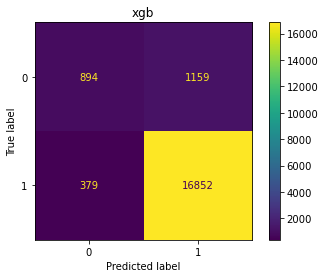

In [18]:
disp = plot_confusion_matrix(pipe_xgb,X_test,y_test)
disp.ax_.set_title('xgb')

#     disp = plot_confusion_matrix(classifier, X_test, y_test,
#                                  display_labels=class_names,
#                                  cmap=plt.cm.Blues,
#                                  normalize=normalize)
#     disp.ax_.set_title(title)

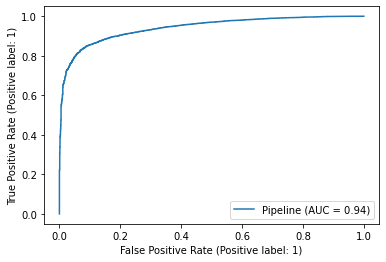

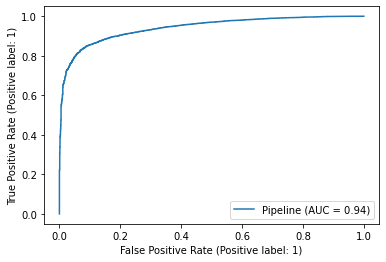

In [19]:
plot_roc_curve(pipe_xgb,X_test,y_test)
plot_roc_curve(pipe_xgb,X_test,y_test)

In [20]:
roc_auc_score(y_test, np.ones(y_test.shape))

0.5

In [21]:
dfresults

,model,acc,auc,conf_mat,num_feat,time,experiment
0,lr,0.893539,0.500000,"[[0, 2053], [0, 17231]]",1,0.051272,Exp. min
1,ridge,0.893539,0.500000,"[[0, 2053], [0, 17231]]",1,0.024311,Exp. min
2,tree,0.893539,0.500000,"[[0, 2053], [0, 17231]]",1,0.035824,Exp. min
3,rf,0.893539,0.500000,"[[0, 2053], [0, 17231]]",1,0.415972,Exp. min
4,gb,0.893539,0.500000,"[[0, 2053], [0, 17231]]",1,1.342852,Exp. min
5,nn,0.893539,0.500000,"[[0, 2053], [0, 17231]]",1,5.957747,Exp. min
6,xgb,0.893539,0.500000,"[[0, 2053], [0, 17231]]",1,1.004333,Exp. min
7,lr,0.974279,0.911595,"[[1708, 345], [151, 17080]]",18,0.613120,base
8,ridge,0.895043,0.512641,"[[55, 1998], [26, 17205]]",18,0.522801,base
9,tree,0.908421,0.668795,"[[748, 1305], [461, 16770]]",18,0.634199,base


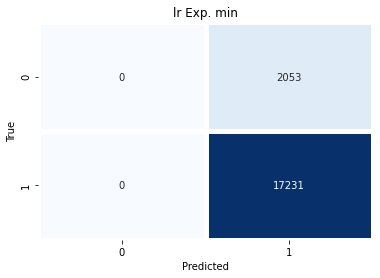

In [22]:
g = sns.heatmap(dfresults.loc[0, 'conf_mat'], annot=True, 
                cbar=False, fmt='', linewidths=5, cmap='Blues')
g.xaxis.set_label_text('Predicted')
g.yaxis.set_label_text('True')
t = g.set_title(dfresults.loc[0, 'model']+ ' '+dfresults.loc[0, 'experiment'])

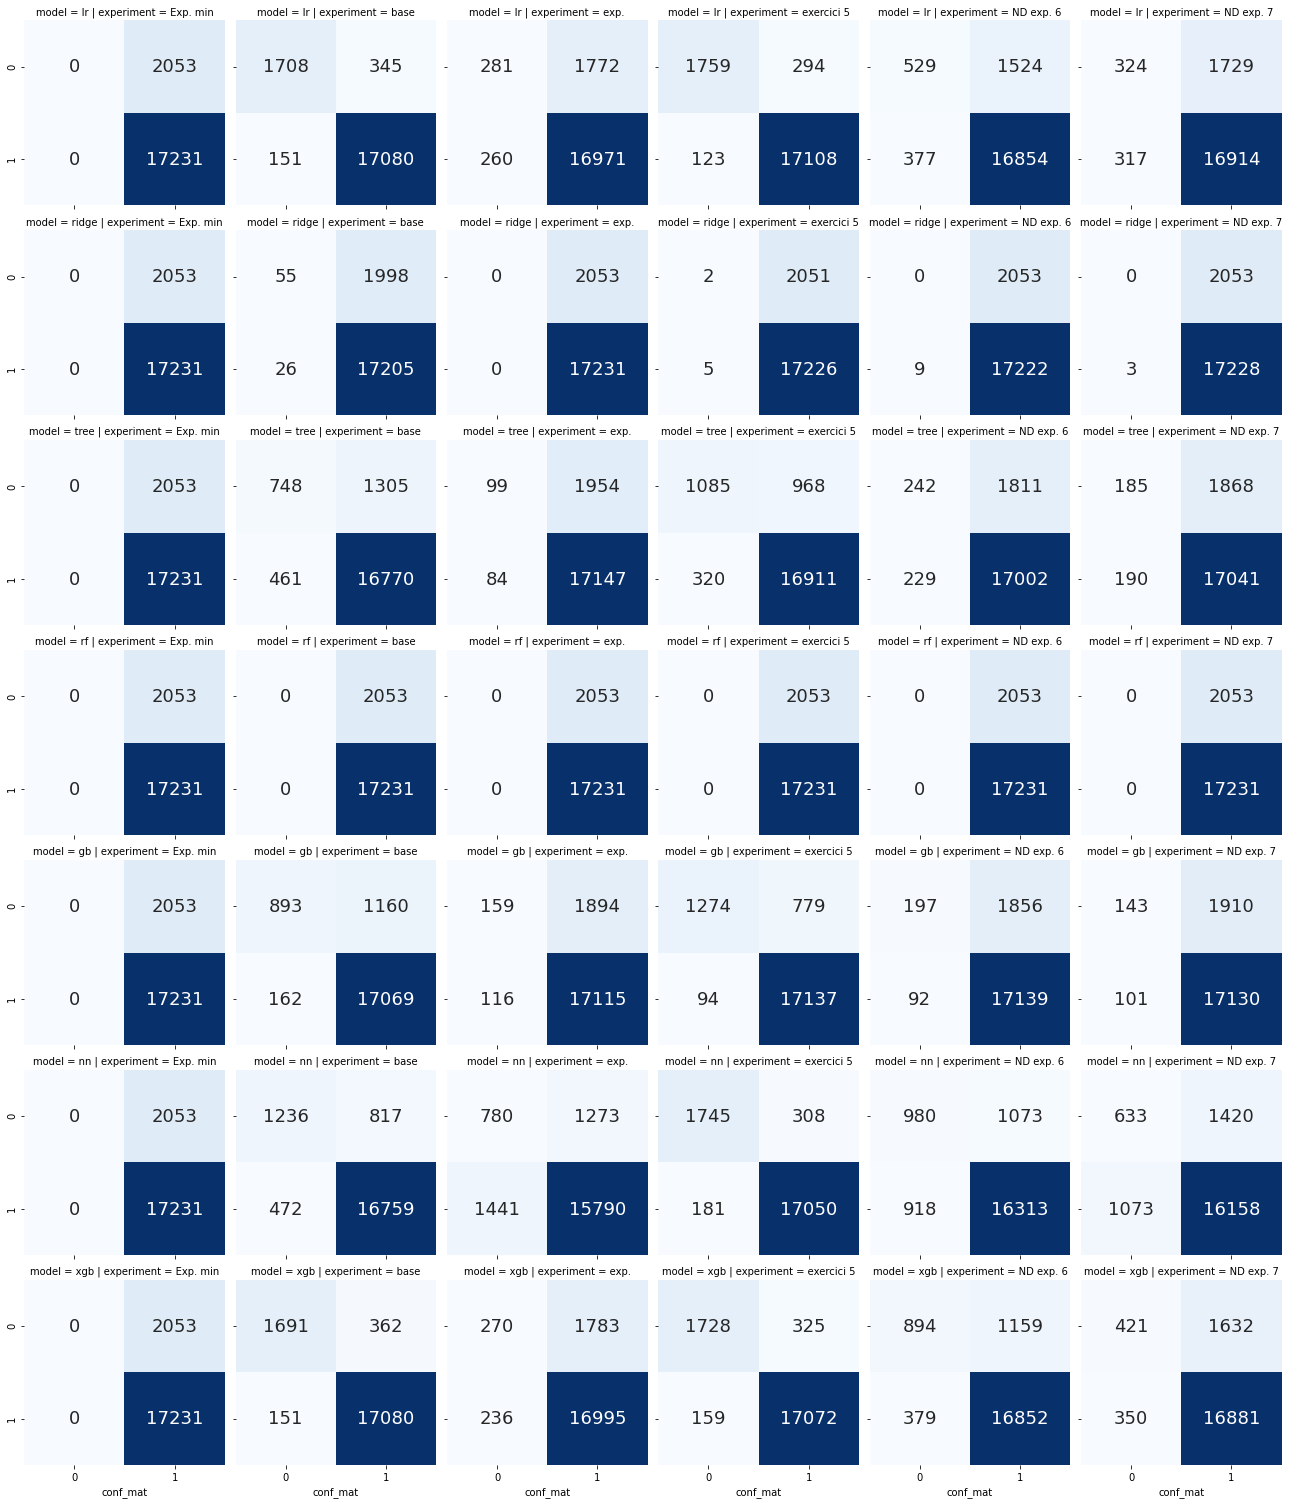

In [23]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.conf_mat
    sns.heatmap(*d.values, **kwargs)

g = sns.FacetGrid(dfresults, col='experiment', row='model', )
# g.map(sns.heatmap, dfresults['conf_mat'])


g.map_dataframe(draw_heatmap, 'conf_mat', annot=True, fmt='', cbar=False,
               annot_kws={"fontsize":18}, cmap='Blues')

#     data = kwargs.pop('data')
#     d = data.pivot(index=args[1], columns=args[0], values=args[2])
#     sns.heatmap(d, **kwargs)

### Exercici 4
Entrena’ls utilitzant els diferents paràmetres que admeten.

### Exercici 5
Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna -CV-).

In [24]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate

cv = 5
X = dfdelays
y = dfdelays[target]

results = []
# models = {'xgb': XGBClassifier(n_jobs=-1)}
for exp, cols in tqdm(experiments.items()):
    for name, model in tqdm(models.items()):
        t0 = time.time()
#         print(model)
        pipe = make_pipeline(X, cols, model )
        score = cross_validate(pipe, X[cols], y, cv=cv, 
                               scoring=['accuracy','f1'],
                               n_jobs=2, verbose=1,  )
    #     results[model] = [scores, scores.mean, t]
        results.append([name, 
                        score['test_accuracy'].mean(),
                        score['test_f1'].mean(),
                        len(cols), 
                        score['fit_time'].sum(),
                        exp])
    

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   16.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   43.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   11.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 17.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  6.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   

In [33]:
dfcvresults = pd.DataFrame(results, 
                           columns=['model','accuracy','f1', 'num_feat','cv_time','experiment'])

In [34]:
dfcvresults.pivot(index=['model'],values=['accuracy','f1','num_feat','cv_time'],columns=['experiment'])\
            .style.set_properties(**{'background-color':'lightyellow'}, subset=['accuracy'])\
                .set_properties(**{'background-color':'lightgreen'}, subset=['f1'])\
                .highlight_max(axis=0, subset=['accuracy','f1'])
#             .set_properties(**{'background-color':'cyan'}, subset=['conf_mat'])
#             .highlight_min(axis=0, subset=['mse','time'])\
#             .highlight_max(axis=0, subset=['r2'])




In [28]:
dfcvresults

,model,accuracy,f1,num_cols,cv_time,experiment
0,lr,0.895456,0.944845,1,0.137318,Exp. min
1,ridge,0.895456,0.944845,1,0.063690,Exp. min
2,tree,0.895456,0.944845,1,0.116406,Exp. min
3,rf,0.895456,0.944845,1,2.919181,Exp. min
4,gb,0.895456,0.944845,1,6.489915,Exp. min
5,nn,0.895456,0.944845,1,26.496721,Exp. min
6,xgb,0.895456,0.944845,1,7.329297,Exp. min
7,lr,0.974030,0.985583,18,2.528171,base
8,ridge,0.896794,0.945422,18,2.095304,base
9,tree,0.909634,0.950811,18,2.731285,base


## Nivell 2
### Exercici 6
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

<div class="alert-info">
    <strong>Info: </strong>Resultat Experiment 5 </div>


## Nivell 3
### Exercici 7
No utilitzis la variable DepDelay a l’hora de fer prediccions

<div class="alert-info">
    <strong>Info: </strong>Resultat Experiments 6 i 7</div>

